# Parametric Mean-Variance Model

This version of the mean-variance model allows for specification of a target return - like in the original formulation. The main difference is the construction of the Mus vector (now starting with the minimum return of an asset and ending with the maximum return) and the construction of the constraint matrices G and h. 

In [18]:
## Libraries and keys
import decimal
import pandas as pd
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
import quandl
# API configuration here
quandl.ApiConfig.api_key = "VAA5bZ67DimoDkvMStuG"
solvers.options['show_progress'] = False
import matplotlib.pyplot as plt

In [104]:
## 1. List of stock tickers 

stocks1 = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB']
stocks2 = ['TIVO', 'JCP', 'F']

# weights for stocks1
Minimal_gewicht1 = 0.0
Maximal_gewicht1 = 0.20
# weights for stocks2
Minimal_gewicht2 = 0.0
Maximal_gewicht2 = 0.20

Scale = 100 
rf = 0.01
target = 0.10

In [105]:
## 2. Getting Data for the stock tickers 

def datafunction(tickers):
    data = quandl.get_table('WIKI/PRICES', ticker = tickers, 
                            qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
                            date = { 'gte': '2016-12-31', 'lte': '2017-12-31' }, 
                            paginate=True)
    new = data.set_index('date')
    # use pandas pivot function to sort adj_close by tickers
    clean_data = new.pivot(columns='ticker')
    return clean_data

stocklist = stocks1 + stocks2
#stocklist = stocklist.sort()
clean_data = datafunction(stocklist)


## 3. Transforming Data for optimization 

returnss = (clean_data.pct_change().dropna())
number = len(stocklist)
returns = returnss.values #as_matrix()

targetlen = target / len(returnss)


## 4. Optimization!

def optimal_portfolio(returns):
    
    n = len(returns)
    N1 = len(stocks1)
    N2 = len(stocks2)
    returns = np.asmatrix(returns)
    
    #G = Scale
    #mus = [10**(5.0 * t/G - 1.0) for t in range(G)]
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    N=Scale
    mus_min=max(min(pbar),0)
    mus_max=max(pbar)
    mus_step=(mus_max - mus_min) / (N-1)
    mus = [mus_min + i*mus_step for i in range(N)]

    S = opt.matrix(np.cov(returns))
    #pbar = opt.matrix(np.mean(returns, axis=1))
    
    #constraint matrices
    dank = -np.array(np.eye(n))
    dabbie = np.array(np.eye(n))
    #ye = np.vstack((dank, dabbie))
    
    dd = np.concatenate((-np.transpose(pbar), dank),0)
    mm = np.concatenate((np.transpose(pbar), dabbie),0)
    ye = np.vstack((dd, mm))
    G = opt.matrix(ye, tc='d')
    
    #G = opt.matrix(np.concatenate((-np.transpose(pbar),ye),0))
    #G = opt.matrix(ye, tc='d')
    
    d1 = -np.ones((N1,1))*Minimal_gewicht1 
    e1 = np.ones((N1,1))*Maximal_gewicht1
    d2 = -np.ones((N2,1))*Minimal_gewicht2
    e2 =  np.ones((N2,1))*Maximal_gewicht2
    min_constraint = np.vstack((d1, d2))
    max_constraint = np.vstack((e1, e2))
    dodo = np.vstack((min_constraint, max_constraint))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    """
    ## Calculate portfolios for efficient frontier (need this to find sharpe optimal portfolio)
    portfolios=[]
    for r_min in mus:
        eee = np.vstack((-np.ones((1,1))*r_min, min_constraint))
        fff = np.vstack((np.ones((1,1))*r_min, max_constraint))
        h = opt.matrix(np.concatenate((eee, fff),0))
        
        #h = opt.matrix(np.concatenate((-np.ones((1,1))*r_min, dodo),0))
        
        sol = solvers.qp(S, -pbar, G, h, A, b)['x']
        portfolios.append(sol)
    """
    
    
    """    
    """
    ## Calculate target return portfolio
    eee = np.vstack((-np.ones((1,1))*targetlen, min_constraint))
    fff = np.vstack((np.ones((1,1))*targetlen, max_constraint))
    h = opt.matrix(np.concatenate((eee, fff),0))
    portfolios = [solvers.qp(S, -pbar, G, h, A, b)['x']]
    

   
    ## Calculate Risk and Return
    returns = np.asarray([blas.dot(pbar, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, S*x)) for x in portfolios])
    
    # Approximates the position of the maximum Sharpe portfolio (also called tangent portfolio)
    # the bigger the 'scale' parameter the more accurate the calculation of the maximum sharpe portfolio!
    slope = (returns-(rf/252))/risks
    sharpe_opt = slope.argmax()

    return  returns, risks, portfolios, G, h, mus, sharpe_opt

exp_returns, exp_risk, weights, G, h, mus, sharpe = optimal_portfolio(returns.T)

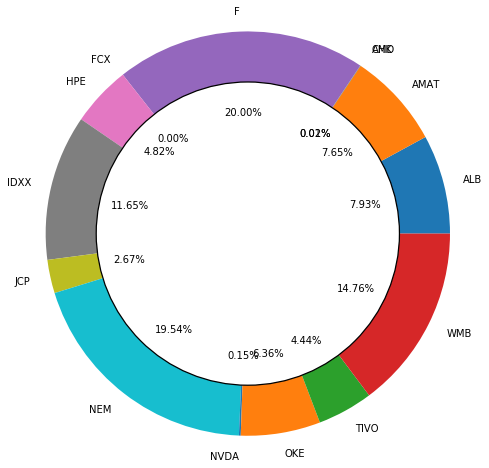

In [109]:
stocklist1 = sorted(stocklist)
labels = stocklist1
weights1 = np.array(weights[0]).tolist()
#explode = (0,0,0,0,0,0,0,0,0,0,0)

plt.pie(weights1, labels=labels, autopct='%.2f%%', shadow=False)
#Add a circle to give dougnut appearance 
circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(circle)
plt.axis('equal')
fig.set_size_inches(8,8)
plt.show()  

In [110]:
## This will print the expected annualized return, this should be the same or very close to the target 

print(exp_returns*len(returnss)*100)

[10.00000003]


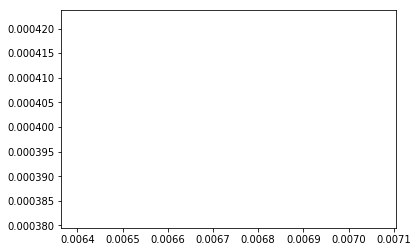

In [113]:
## If multiple portfolios are selected, this will show the efficient frontier

plt.plot(exp_risk, exp_returns)